<a href="https://colab.research.google.com/github/teadrinke/machine-learning/blob/main/Encrytion_Decryption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import string
import random
import re
import requests
import os
import textwrap

In [ ]:
#creating a cipher
#to create a mapping which we donot know for a-z
letters1 = list(string.ascii_lowercase)
letters2 = list(string.ascii_lowercase)

true_mapping = {}

random.shuffle(letters2)

#populating the dictionary
for k,v in zip(letters1, letters2):
  true_mapping[k] = v

In [ ]:
#building the language model
pi = np.zeros(26)
A = np.ones((26,26))

def add_to_pi(ch):
  # ord('a') = 97, ord('b') = 98, ...
  idx = ord(ch) - 97
  pi[idx] += 1

def add_to_A(ch1,ch2):
  # ord('a') = 97, ord('b') = 98, ...
  idx1 =  ord(ch1) - 97
  idx2 = ord(ch2) - 97
  A[idx1, idx2] += 1

def word_to_prob(word):
  i = ord(word[0]) - 97
  logp = np.log(pi[i])

  for ch in word[1:]:
    
    j = ord(ch) - 97
    logp += np.log(A[i,j]) #update prob
    i = j #update j

  return logp

def sente_to_prob(input1):
  if type(input1) == str:
    tokens = input1.split()
  prob = 0
  for k in tokens:
    temp = word_to_prob(k)
    prob += temp

  return prob


In [ ]:
### create a markov model based on an English dataset
if not os.path.exists('moby_dick.txt'):
  print("Downloading moby dick...")
  r = requests.get('https://lazyprogrammer.me/course_files/moby_dick.txt')
  with open('moby_dick.txt', 'w') as f: #opening in the write mode
    f.write(r.content.decode())

In [ ]:
# for replacing non-alpha characters
regex = re.compile('[^a-zA-Z]')

#loading the data into pi and A 
for line in open('moby_dick.txt'):

  if line:
    line = regex.sub(' ', line) #replace all non-alpha characters by white space
    line = line.rstrip().lower()

  tokens = line.lower().split()

  for token in tokens:
    ch0 = token[0]
    add_to_pi(ch0)

    for i in token[1:]:
      add_to_A(ch0,i)
      ch0 = i
#normalize pi and A
pi /= pi.sum()
A /= A.sum(axis=1, keepdims=True)

In [ ]:
### encode a message

# this is a random excerpt from Project Gutenberg's
# The Adventures of Sherlock Holmes, by Arthur Conan Doyle
# https://www.gutenberg.org/ebooks/1661

original_message = '''I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was compelled to listen to.
'''

# Away they went, and I was just wondering whether I should not do well
# to follow them when up the lane came a neat little landau, the coachman
# with his coat only half-buttoned, and his tie under his ear, while all
# the tags of his harness were sticking out of the buckles. It hadn't
# pulled up before she shot out of the hall door and into it. I only
# caught a glimpse of her at the moment, but she was a lovely woman, with
# a face that a man might die for.

# My cabby drove fast. I don't think I ever drove faster, but the others
# were there before us. The cab and the landau with their steaming horses
# were in front of the door when I arrived. I paid the man and hurried
# into the church. There was not a soul there save the two whom I had
# followed and a surpliced clergyman, who seemed to be expostulating with
# them. They were all three standing in a knot in front of the altar. I
# lounged up the side aisle like any other idler who has dropped into a
# church. Suddenly, to my surprise, the three at the altar faced round to
# me, and Godfrey Norton came running as hard as he could towards me.

In [ ]:
#encoding the message

def encode_msg(msg):
  msg = msg.lower()

  msg = regex.sub(' ', msg)

  coded_msg = []
  for ch in msg:
    coded_ch = ch #could just be a space
    if ch in true_mapping:
      coded_ch = true_mapping[ch]
    coded_msg.append(coded_ch)

  return ''.join(coded_msg)

encoded_message = encode_msg(original_message)

#decoding the message
def decode_msg(msg, word_map):
    msg = msg.lower()

    msg = regex.sub(' ', msg)

    decoded_msg = []

    for ch in msg:
      decoded_ch = ch
      if ch in word_map:
        decoded_ch = word_map[ch]
      decoded_msg.append(decoded_ch)

    return ''.join(decoded_msg)



In [ ]:
#run an evolutionary/genetic algorithm to decode the message
dna_pool = []

for i in range(20):
  dna= list(string.ascii_lowercase) #returns all lowercase letters in the form of list
  random.shuffle(dna)
  dna_pool.append(dna)

  

In [ ]:
#how to create offspring 
def evolve_offspring(dna_pool, no_of_child):
  offspring = []

  for dna in dna_pool:
    for i in range(no_of_child):
      copy = dna.copy()
      j = np.random.randint(len(copy))
      k = np.random.randint(len(copy))

      #swapping
      temp = copy[j]
      copy[j] = copy[k]
      copy[k] = temp

      offspring.append(copy)

  return   offspring + dna_pool

In [ ]:
num_iters = 5000
scores = np.zeros(num_iters)
best_dna = None
best_map = None
best_score = float('-inf')
for i in range(num_iters):
  if i> 0:
    dna_pool = evolve_offspring(dna_pool,3)
  dna2score = {}
  
  for dna in dna_pool:

    current_map = {}

    for k,v in zip(letters1, dna):
      current_map[k] = v
    
    decoded_message = decode_msg(encoded_message, current_map)
    score = sente_to_prob(decoded_message)

    dna2score[''.join(dna)] = score
    if score>best_score:
      best_score = score
      best_map = current_map
      best_dna = dna
  scores[i] = np.mean(list(dna2score.values()))

  sorted_dna = sorted(dna2score.items(), key=lambda x: x[1], reverse= True)
  dna_pool = [list(k) for k,v in sorted_dna[:5]]
  if i % 200 == 0:
    print("iter:", i, "score:", scores[i], "best so far:", best_score)

iter: 0 score: -2100.0697647048737 best so far: -1834.852927955895
iter: 200 score: -1037.5779114626482 best so far: -952.6801420996765
iter: 400 score: -1004.5840892864102 best so far: -929.5902922650557
iter: 600 score: -1027.8997834633237 best so far: -929.5902922650557
iter: 800 score: -999.783310305305 best so far: -929.5902922650557
iter: 1000 score: -1021.4046502110043 best so far: -929.5902922650557
iter: 1200 score: -1011.2537514249107 best so far: -929.5902922650557
iter: 1400 score: -1027.4562565767158 best so far: -929.5902922650557
iter: 1600 score: -988.2861217643319 best so far: -929.5902922650557
iter: 1800 score: -1003.5936040929325 best so far: -929.5902922650557
iter: 2000 score: -997.369558574045 best so far: -929.5902922650557
iter: 2200 score: -1043.9309897030248 best so far: -929.5902922650557
iter: 2400 score: -1015.6406590906728 best so far: -929.5902922650557
iter: 2600 score: -1012.3945857074771 best so far: -929.5902922650557
iter: 2800 score: -1011.32903971

In [ ]:
# use best score
decoded_message = decode_msg(encoded_message, best_map)

print("LL of decoded message:", sente_to_prob(decoded_message))
print("LL of true message:", sente_to_prob(regex.sub(' ', original_message.lower())))


# which letters are wrong?
for true, v in true_mapping.items():
  pred = best_map[v]
  if true != pred:
    print("true: %s, pred: %s" % (true, pred))

LL of decoded message: -929.5902922650557
LL of true message: -933.0312453751817
true: j, pred: q
true: k, pred: j
true: q, pred: z
true: z, pred: k


In [ ]:
# print the final decoded message
print("Decoded message:\n", textwrap.fill(decoded_message))

print("\nTrue message:\n", original_message)

Decoded message:
 i then lounged down the street and found  as i expected  that there
was a mews in a lane which runs down by one wall of the garden  i lent
the ostlers a hand in rubbing down their horses  and received in
exchange twopence  a glass of half and half  two fills of shag tobacco
and as much information as i could desire about miss adler  to say
nothing of half a doken other people in the neighbourhood in whom i
was not in the least interested  but whose biographies i was compelled
to listen to

True message:
 I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was 

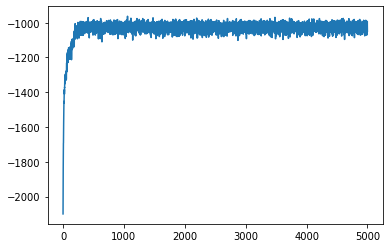

In [ ]:
plt.plot(scores)
plt.show()